# Diamond sensor data collection and analysis

xchong@lbl.gov, awojdyla@lbl.gov, May 2024

# Step 1: Move the m101 pitch slightly and see what happens

In [1]:
import epics
import bluesky
import numpy as np

In [2]:
from bluesky import RunEngine
RE = RunEngine({})

from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

0

In [ ]:
from ophyd import EpicsMotor
import ophyd
#ophyd.set_cl('caproto')

#for diode_mA, use EpicsSignal() instead of EpicsMotor
diode_mA = ophyd.EpicsSignal('bl201-beamstop:current', name='photodiode') 
diode_mA.wait_for_connection(timeout=2.0)
diode_mA.read()

In [ ]:
#For the 1st experiment on 20231215, we use mono_angle_deg only (which does not work, no edge found)
#pv_mono_angle_deg = 'bl531_xps1:mono_angle_deg'
#pv_photodiode_mA  = 'bl201-beamstop:current'


pv_m101_pitch_mm  = 'bl531_esp300:m101_pitch_mm'
# #pv_m101_bend_um   = 'bl531_esp300:m101_bend_um'
# pv_mono_height_mm = 'bl531_xps1:mono_height_mm'

In [ ]:
m101_pitch_mm = EpicsMotor(pv_m101_pitch_mm, name='m101_pitch_mm')
m101_pitch_mm.wait_for_connection(timeout=2.0)
m101_pitch_mm.read()

In [ ]:
#Run this line before starting angle scan, otherwise the edge does not look good
m101_pitch_mm.read()

In [ ]:
m101_pitch_mm.move(0.819982)

# Step 2 Get the diamond sensor image

# parse the ice-cream data

In [2]:
def find_all(sub,s):
    index_list=[]
    index = s.find(sub)
    while index!=-1:
        index_list.append(index)
        index = s.find(sub,index+1)
    if len(index_list)>0:
        return index_list
    else:
        return -1

In [3]:
import subprocess
import numpy as np

# cmd = "pvget ice-cream/image"
# process = subprocess.Popen(cmd.split(),
#                      stdout=subprocess.PIPE)
# processed, _ = process.communicate()
# ice_cream= processed.decode("utf-8")
# x = ice_cream.split('\n')
# for i in range (len(x)):
#     print(i,x[i])
# start = find_all("[",x[2])[-1]
# end = find_all("]",x[2])[-1]
# value = x[2][start+1:end].split(',')
# res = [eval(i) for i in value]
# res = np.resize(np.array(res),(50,48))
# process.kill()
# process.terminate()

In [35]:
import subprocess
output = subprocess.getoutput('pvget ice-cream/image')
x = output.split('\n')
for i in range (len(x)):
    print(i,x[i])
start = find_all("[",x[2])[-1]
end = find_all("]",x[2])[-1]
value = x[2][start+1:end].split(',')
res = [eval(i) for i in value]
res = np.resize(np.array(res),(48,50))

0 ice-cream/image structure 
1     any value
2         int[]  [-65,40,-45,41,-6,17,-16,31,-14,22,-19,23,-26,12,47,-22,2,9,17,0,34,-41,35,-52,33,-29,42,-21,35,-28,66,-17,51,-27,63,-43,43,3,17,17,15,14,7,-22,-2,-32,-14,2,8,55,14,26,10,8,25,-15,3,26,26,5,-14,18,23,29,32,0,2,7,17,-24,26,11,4,5,1,28,3,-4,37,-18,24,0,13,19,78,10,1,23,-5,-6,-17,-20,-15,9,3,6,-4,-7,25,8,-59,39,-59,14,-29,31,-38,22,-20,19,-25,-17,-9,-1,15,-10,5,-10,10,-20,23,-17,23,-35,44,-8,30,-24,8,-33,45,-45,29,-23,45,-29,47,12,22,-13,27,15,50,-1,6,-19,1,2,-31,13,6,15,28,-15,35,-8,-15,20,-8,22,9,29,10,1,23,-21,-4,6,20,-14,-5,18,-1,9,7,13,6,-9,26,-7,11,13,-10,16,36,20,5,34,-5,-6,20,13,-10,27,-5,-22,6,20,6,-8,-22,30,-5,-3,-8,29,-8,-3,-13,2,14,4,-10,4,18,-13,9,0,15,-19,18,-1,27,-25,35,-18,14,-15,-6,-7,10,-22,17,-34,21,-9,12,17,6,-12,5,-3,30,-5,31,25,19,3,-12,11,4,7,18,8,31,13,2,25,15,12,-11,49,-1,10,19,4,8,-10,9,-18,27,3,1,-18,21,-14,28,-21,21,-11,31,-12,18,15,47,14,14,17,4,-22,-15,-21,13,25,-13,-31,-20,-7,45,8,-10,12,-33,6,3,-

In [5]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
# subprocess = os.popen('pvget ice-cream/image')
# ice_cream = subprocess.read()
# x = ice_cream.split('\n')
# for i in range (len(x)):
#     print(i,x[i])
# start = find_all("[",x[2])[-1]
# end = find_all("]",x[2])[-1]
# value = x[2][start+1:end].split(',')
# res = [eval(i) for i in value]
# res = np.resize(np.array(res),(50,48))
# subprocess.close()


## calculate size and center for the collected gaussian source

In [6]:
def centroid1(x_px,I):
    xc_px = np.sum(I*x_px)/np.sum(I)
    return xc_px

def size_rms1(x_px,I):
    xc_px = centroid1(x_px,I)
    stdev = np.sqrt(np.sum(I*(x_px-xc_px)**2)/np.sum(I))
    return stdev

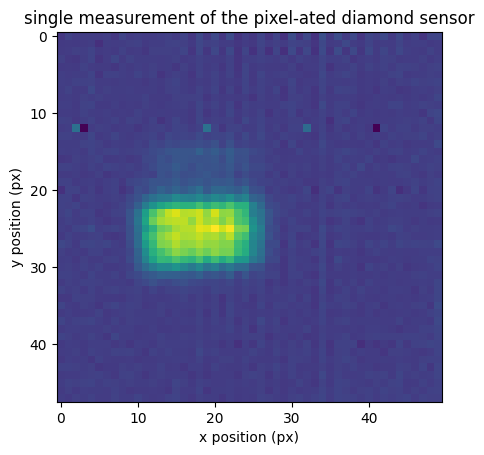

In [70]:
Nx = 50
x_px = np.arange(Nx)
Ny = 48
y_px = np.arange(Ny)


source_gaussian = res
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")
plt.imshow(source_gaussian)
plt.show()

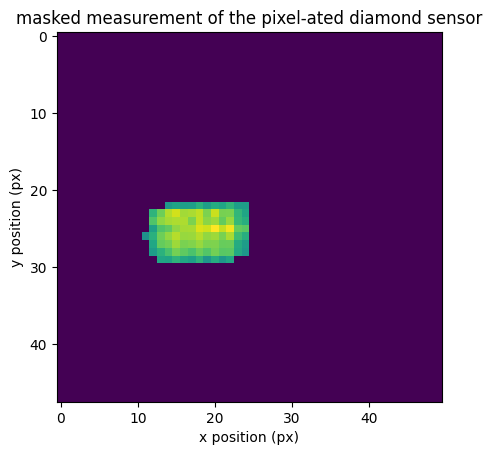

In [69]:
source_gaussian_masked = np.where(source_gaussian>(0.5*np.max(source_gaussian)),source_gaussian,0)
plt.imshow(source_gaussian_masked)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("masked measurement of the pixel-ated diamond sensor")
plt.show()

In [16]:
center_x_px = centroid1(x_px, np.sum(source_gaussian_masked,0))
size_x_px = size_rms1(x_px, np.sum(source_gaussian_masked,0))
print("x-axis center and size:",center_x_px,size_x_px*2.35)

center_y_px = centroid1(y_px, np.sum(source_gaussian_masked,1))
size_y_px = size_rms1(y_px, np.sum(source_gaussian_masked,1))
print("y-axis center and size:",center_y_px,size_y_px*2.35)

x-axis center and size: 18.310623449131512 8.300602290082619
y-axis center and size: 25.169308312655087 4.579690610257997


# Step 3 collect 100 images and save locally

In [18]:
from PIL import Image
from tqdm import tqdm
import time


number_of_data = 100
data = np.zeros((number_of_data*10,48,50))

In [41]:
# for i in tqdm(range(number_of_data)):
#     subprocess = os.popen('pvget ice-cream/image')
#     ice_cream = subprocess.read()
#     x = ice_cream.split('\n')
    
#     start = find_all("[",x[2])[-1]
#     end = find_all("]",x[2])[-1]
#     value = x[2][start+1:end].split(',')
#     res = [eval(i) for i in value]
#     res = np.resize(np.array(res),(50,48))
#     data[i]=res
#     subprocess.close()
    
#     time.sleep(1)

# for i in tqdm(range(number_of_data)):
#     cmd = "pvget ice-cream/image"
#     process = subprocess.Popen(cmd.split(),
#                         stdout=subprocess.PIPE)
#     processed, _ = process.communicate()
#     ice_cream= processed.decode("utf-8")
#     x = ice_cream.split('\n')

#     start = find_all("[",x[2])[-1]
#     end = find_all("]",x[2])[-1]
#     value = x[2][start+1:end].split(',')
#     res = [eval(i) for i in value]
#     res = np.resize(np.array(res),(50,48))
#     data[i]=res
#     process.kill()
#     process.terminate()
#     time.sleep(1)

folder_index=9

save_path = '/home/bl531/Documents/diamond_images_0603/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in tqdm(range(number_of_data)):
    output = subprocess.getoutput('pvget ice-cream/image')
    x = output.split('\n')
    start = find_all("[",x[2])[-1]
    end = find_all("]",x[2])[-1]
    value = x[2][start+1:end].split(',')
    res = [eval(i) for i in value]
    res = np.resize(np.array(res),(48,50))
    #print(res)

    save_image_path = save_path + 'images_tiff_'+str(folder_index)+'/'
    if not os.path.exists(save_image_path):
        os.makedirs(save_image_path)

    im = Image.fromarray(res.astype(np.float32))
    im.save(save_image_path+str(i)+'.tiff',"tiff")

    #data[folder_index*100+i]=res



100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Text(0.5, 1.0, 'single measurement of the pixel-ated diamond sensor')

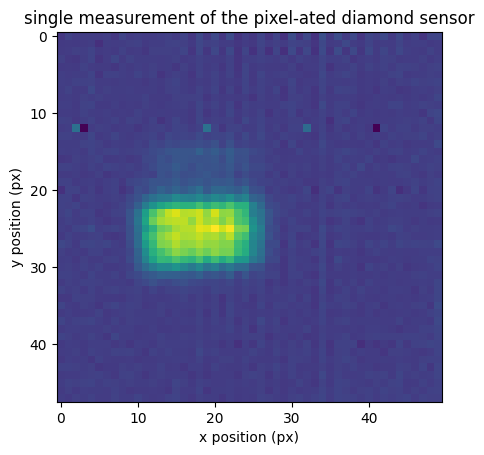

In [71]:
test_index =99
im_png = Image.open(save_path + 'images_tiff_9/'+str(test_index)+'.tiff')
im_png_arr = np.array(im_png)
plt.imshow(im_png_arr)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")

In [ ]:


#for i_a in tqdm(np.arange(len(mono_angles_deg))):

## choice 1: save all images to .h5 file

In [25]:
import h5py

save_path = '/home/bl531/Documents/diamond_images/'
h5f = h5py.File(save_path + 'dataset'+str(folder_index)+'.h5','w')
h5f.create_dataset('diamond_dataset',data = data)
h5f.close()

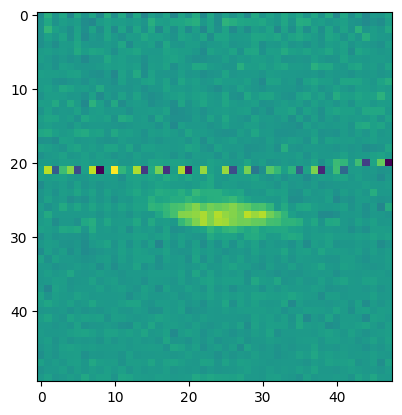

In [27]:
h5f=h5py.File(save_path+'dataset.h5', 'r')
data = h5f['diamond_dataset']
plt.imshow(data[0])
h5f.close()

## choice 2 : save each image separately to png file

In [ ]:
from PIL import Image
for j in range(number_of_data):
    image_arr = data[i]
    save_image_path = save_path + 'images_png/'
    if not os.path.exists(save_image_path):
        os.makedirs(save_image_path)
    im = Image.fromarray(image_arr)
    im = im.convert("L")# 8 bit ints and 8-bit depth for grayscale image
    im.save(save_image_path+str(j)+'.png')


In [ ]:
test_index =1
im_png = Image.open(save_path + 'images_png/'+str(test_index)+'.png')
im_png_arr = np.array(im_png)
plt.imshow(im_png_arr)

## choice 3 save each image separately to tiff file

In [ ]:
for j in range(number_of_data):
    image_arr = data[i]
    save_image_path = save_path + 'images_tiff/'
    if not os.path.exists(save_image_path):
        os.makedirs(save_image_path)

    im = Image.fromarray(image_arr)
    im.save(save_image_path+str(j)+'.tiff',"tiff")

In [ ]:
test_index =1
im_png = Image.open(save_path + 'images_tiff/'+str(test_index)+'.tiff')
im_png_arr = np.array(im_png)
plt.imshow(im_png_arr)

# Step 4: get the avg of 100 images and cal center/size

(900, 48, 50)


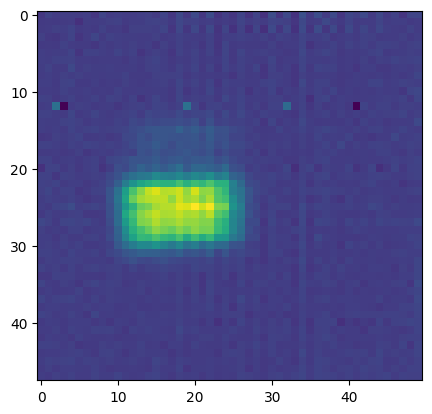

In [55]:
save_path = '/home/bl531/Documents/diamond_images_0603/'
data = np.zeros((900,48,50))
for folder in range (9):
    for i in range (100):
        filename = save_path + 'images_tiff_'+str(folder+1)+'/'+str(i)+'.tiff'
        #print(filename)
        im_png = Image.open(filename)
        im_png_arr = np.array(im_png)
        data[folder*100+i]=im_png_arr
print(data.shape)
plt.imshow(data[-1])
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("single measurement of the pixel-ated diamond sensor")

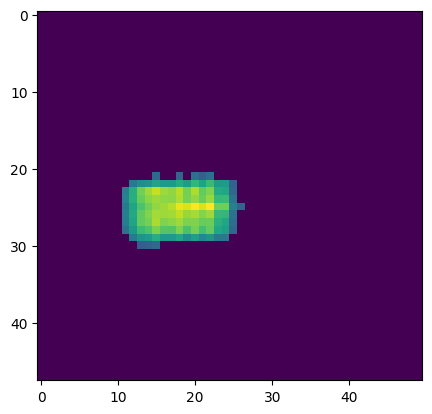

In [56]:
data_avg = np.mean(data,0)
data_avg_masked = np.where(data_avg>(0.3*np.max(data_avg)),data_avg,0)
plt.imshow(data_avg_masked)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("masked measurement of the pixel-ated diamond sensor")

In [57]:
avg_center_x_px = centroid1(x_px, np.sum(data_avg_masked,0))
avg_size_x_px = size_rms1(x_px, np.sum(data_avg_masked,0))*2.35
print("x-axis center and size:",avg_center_x_px,avg_size_x_px)
avg_center_y_px = centroid1(y_px, np.sum(data_avg_masked,1))
avg_size_y_px = size_rms1(y_px, np.sum(data_avg_masked,1))*2.35
print("y-axis center and size:",avg_center_y_px,avg_size_y_px)

x-axis center and size: 18.019396384119894 9.137061135840677
y-axis center and size: 25.373080510140394 5.2382680421953305


## create a fake gaussian with same center and size

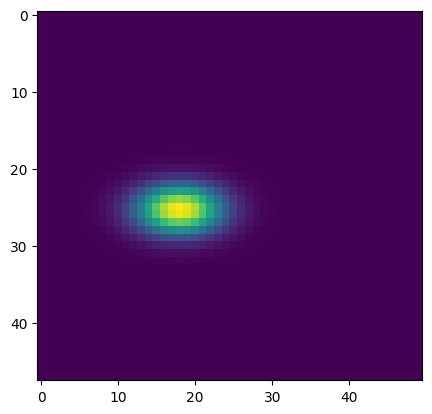

In [58]:
#define the gaussian function
def gaussian(x_px, mean_px, fwhm_px):
    '''
    GAUSSIAN Returns a 1D gaussian
    gaussian(x_px, mean_px, fwhm_px)
    :param x_px: numpy array
    :param mean_px: double
    :param fwhm_px: double
    :return: numpy array
    '''
    sigma_x = fwhm_px/(2*np.sqrt(2*np.log(2)))
    return np.exp(-((x_px-mean_px)/(np.sqrt(2)*sigma_x))**2)
X,Y = np.meshgrid(x_px,y_px)
fake_gaussian = gaussian(X, avg_center_x_px, avg_size_x_px)*gaussian(Y, avg_center_y_px, avg_size_y_px)
plt.imshow(fake_gaussian)
plt.xlabel("x position (px)")
plt.ylabel("y position (px)")
plt.title("fake gaussian simulation")

In [59]:
center_x_list=[]
size_x_list=[]
center_y_list=[]
size_y_list=[]
for k in range(data.shape[0]):
    each_data = data[k]

    each_center_x_px = centroid1(x_px, np.sum(each_data,0))
    each_size_x_px = size_rms1(x_px, np.sum(each_data,0))*2.35
    each_center_y_px = centroid1(y_px, np.sum(each_data,1))
    each_size_y_px = size_rms1(y_px, np.sum(each_data,1))*2.35

    center_x_list.append(each_center_x_px)
    size_x_list.append(each_size_x_px)
    center_y_list.append(each_center_y_px)
    size_y_list.append(each_size_y_px)

0.4784921844763858


Text(0, 0.5, 'frequency')

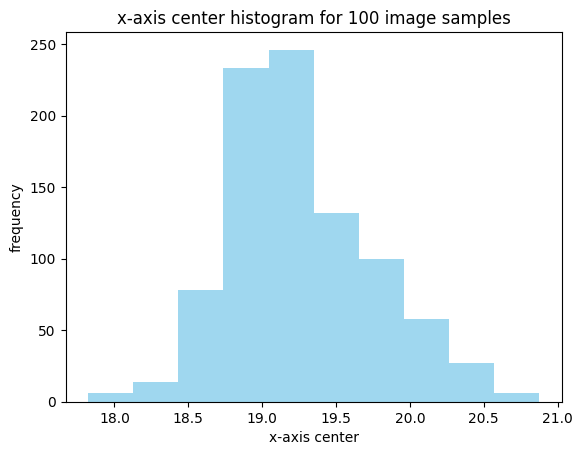

In [61]:

#print(len(center_x_list))
#print(center_x_list)
print(np.std(center_x_list))
plt.hist(center_x_list, bins=10,color='skyblue',alpha=0.8)
plt.title('x-axis center histogram for 100 image samples')
plt.xlabel('x-axis center (px)')
plt.ylabel('frequency')

1.0132906809298898


Text(0, 0.5, 'frequency')

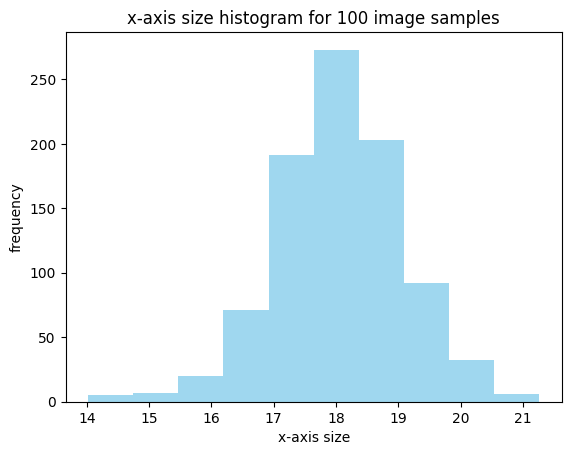

In [64]:
print(np.std(size_x_list))
plt.hist(size_x_list, bins=10,color='skyblue',alpha=0.8)
plt.title('x-axis size histogram for 100 image samples')
plt.xlabel('x-axis size (px)')
plt.ylabel('frequency')

0.16728574949631128


Text(0, 0.5, 'frequency')

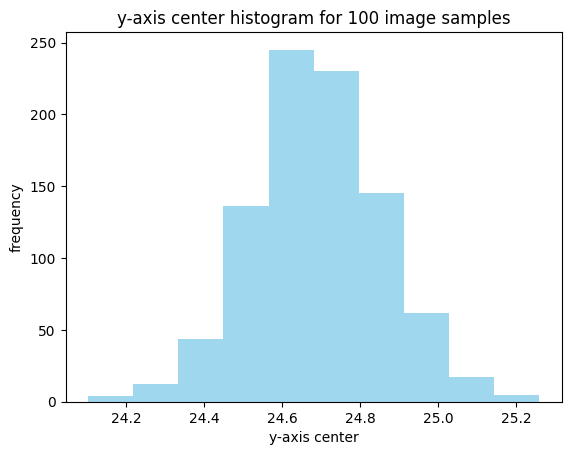

In [65]:
print(np.std(center_y_list))
plt.hist(center_y_list, bins=10,color='skyblue',alpha=0.8)
plt.title('y-axis center histogram for 100 image samples')
plt.xlabel('y-axis center (px)')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

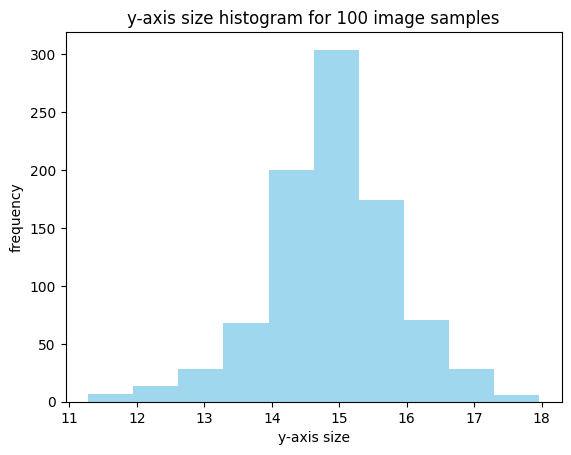

In [66]:
plt.hist(size_y_list, bins=10,color='skyblue',alpha=0.8)
plt.title('y-axis size histogram for 100 image samples')
plt.xlabel('y-axis size (px)')
plt.ylabel('frequency')

# calculate the time for collecting one image

In [57]:
import time
start_time = time.time()
ice_cream_testtime = os.popen('pvget ice-cream/image').read()
end_time = time.time()
time = end_time-start_time
print("time(s) for collecting one image",time)

KeyboardInterrupt: 